In [11]:
import matplotlib.pyplot as plt
from ultis import *
from docplex.mp.model import Model
%matplotlib widget

### Create functions to define LP

In [12]:
def define_variables(costs, model):
    var = set()
    for ijk in costs.keys():
        i, j, k = ijk[0], ijk[1], ijk[2]
        var.add((i, j))
        var.add((j, k))
    var = sorted(var, key=lambda x: (x[0], x[1]))
    x = model.binary_var_dict(var, name='x')
    z = model.continuous_var_dict(list(costs.keys()),name='z', lb=0,ub=1)
    return x, z


In [13]:
def create_model(costs, hits, hits_by_layers, alpha, model_path_out):
    NL = len(hits_by_layers.keys())
    print("Number of layers: ", NL)

    model = Model(name="Track finding")
    model.float_precision = 8
    x, z = define_variables(costs, model)
    ob_funct = model.sum(-w * alpha * x[(ijk[0], ijk[1])] * x[(ijk[1], ijk[2])] for ijk, w in costs.items())
    model.minimize(ob_funct)
    
    for h in hits:
        k = h.index
        constraint_out = []
        constraint_in = []
        for k_1 in x.keys():
            if ((h.layer_id < (NL - 1)) and (k_1[0] == k)):
                constraint_out.append(x[(k_1[0], k_1[1])])
            if ((h.layer_id > 0) and (k_1[1] == k)):
                constraint_in.append(x[(k_1[0], k_1[1])])
        if (len(constraint_out) > 0):
            model.add_constraint(model.sum(constraint_out) == 1)
        if (len(constraint_in) > 0):
            model.add_constraint(model.sum(constraint_in) == 1)
    
    # addition constaint
    for i_j_k in costs.keys():
        i_j = (i_j_k[0], i_j_k[1])
        j_k =  (i_j_k[1], i_j_k[2])
        model.add_constraint(x[i_j] + x[j_k] - z[i_j_k]<=1)
        model.add_constraint(z[i_j_k]<=x[i_j])
        model.add_constraint(z[i_j_k]<=x[j_k])

    model.export_as_lp(model_path_out)
    model.print_information()
    return model


In [14]:
def solve_lp(model, solution_path_out):
    model.solve(log_output=True)
    
    if model.solution == None:
        print("No solution!")
        return None
    else:
        model.solution.export(solution_path_out)

        f = open(solution_path_out)
        result = json.load(f)
        f.close()
        solution = result['CPLEXSolution']['variables']
        ob_value = float(result['CPLEXSolution']['header']['objectiveValue'])
        return ob_value, solution

### Display result

In [15]:
def display(hits, result, out=""):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    xs = []
    ys = []
    zs = []

    for h in hits:
        xs.append(h.x)
        ys.append(h.y)
        zs.append(h.z)
    ax.scatter(xs, ys, zs, marker='o', color='red')

    count_segments = 0
    for var in result:
        # print(var)
        x_i_j = var['name'].split('_')
        if 'x' in x_i_j[0] and round(float(var['value'])) == 1.0:
            count_segments += 1
            i = int(x_i_j[1])
            j = int(x_i_j[2])
            h1 = hits[i]
            h2 = hits[j]
            ax.plot(xs=[h1.x, h2.x], ys=[h1.y, h2.y], zs=[h1.z, h2.z], color='blue')
    print("No. segments by model :", count_segments)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.savefig(out)
    plt.show()


In [16]:
def run_script(no_tracks, beta_max, m, alpha):
    src_path = '../../src/data_selected'
    folder = '/'+ str(no_tracks)+'hits/known_track/'
    out_path = 'results'
    data_path = src_path + folder + 'hits.csv'
    figure_path_out = out_path + folder + "result_C_LP.PNG"
    check_path(out_path + folder)
    
    # read data
    print("Loading data...")
    start = time.time()
    hits_by_layers, hits = read_hits(data_path)
    end = time.time()
    print("Loaded data! Execution time: ", end - start)

    re_calculate = False
    costs_path_out = out_path + folder + "pi_" + str(A) + "costs.json"
    if os.path.exists(costs_path_out) == False:
        re_calculate = True
    if re_calculate:
        # calculate costs
        print("\n----Compute cost----")
        start = time.time()
        costs = get_costs(hits_by_layers, beta_max)
        end = time.time()
        print('Complete!. Execution time: ', end - start, 's')
    
        print("\n---Write cost out---")
        print("Path: ", costs_path_out)
        write_costs(costs, costs_path_out, m)
    
    # load data
    print("---Load cost---")
    costs = load_costs(costs_path_out)
    print("---Loaded cost---")

    print("\n ----Create LP----")
    model_path_out = out_path + folder + "model_C_LP.lp"
    model = create_model(costs, hits, hits_by_layers, alpha, model_path_out)
    print("----Created LP----")

    
    print("\n----Solving----")
    solution_path_out = out_path + folder + "solution_C_LP.json"
    ob_value, solution = solve_lp(model, solution_path_out)
    print("Objective value:", ob_value / alpha)
    cal_expected_value(hits, m)
    display(hits, solution, out=figure_path_out)

Loading data...
Loaded data! Execution time:  0.010161876678466797
---Load cost---
---Loaded cost---

 ----Create LP----
Number of layers:  7
Model: Track finding
 - number of variables: 222
   - binary=90, integer=0, continuous=132
 - number of constraints: 462
   - linear=462
 - parameters: defaults
 - objective: minimize quadratic
 - problem type is: MIQP
----Created LP----

----Solving----
Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Found incumbent of value -10.416010 after 0.00 sec. (0.04 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 462 rows and 222 columns.
All rows and columns eliminated.
Presolve time = 0.00 sec. (0.27 ticks)

Root node processing (before b&c):
  Real time             =    0.00 sec. (0.33 ticks)
Parallel b&c, 8 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Tota

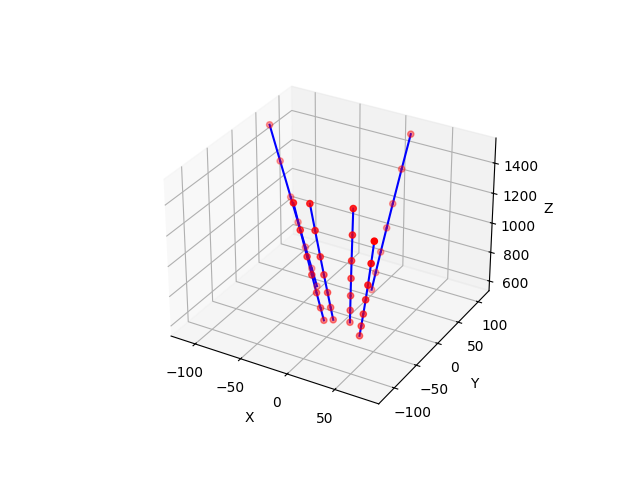

In [30]:
if __name__ == '__main__': # Keep this line if we want to run multiprocessing
    no_tracks = 6
    A = 500
    beta_max = math.pi / A
    m = 1
    alpha = 100
    run_script(no_tracks, beta_max, m, alpha)